# Image classification on MNIST Fashion dataset

In [105]:
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

print(tf.__version__)

!rm -rf ./logs/
%load_ext tensorboard

2.3.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Dataset

- The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255.
- The labels are an array of integers, ranging from 0 to 9.

| Label     | Class |
| ----------- | ----------- |
| 0   | T-shirt/top       |
| 1   | Trouser        |
| 2   | Pullover        |
| 3   | Dress        |
| 4   | Coat        |
| 5   | Sandal        |
| 6   | Shirt        |
| 7   | Sneaker        |
| 8   | Bag        |
| 9   | Ankle boot        |

In [106]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [107]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Data Exploration

In [108]:
print('\n Shape (training-set ):',train_images.shape)
print('\n Shape (testing-set ):',test_images.shape)


 Shape (training-set ): (60000, 28, 28)

 Shape (testing-set ): (10000, 28, 28)


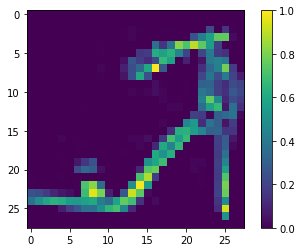

Shape:  (28, 28)
Label:  5 -> Sandal


In [188]:
plt.figure()
plt.imshow(train_images[8])
plt.colorbar()
plt.grid(False)
plt.show()

print("Shape: ", train_images[8].shape)
print("Label: ", train_labels[8], "->", class_names[train_labels[8]])

In [110]:
# normalizing pixel values 0-1

train_images = train_images / 255.0
test_images = test_images / 255.0

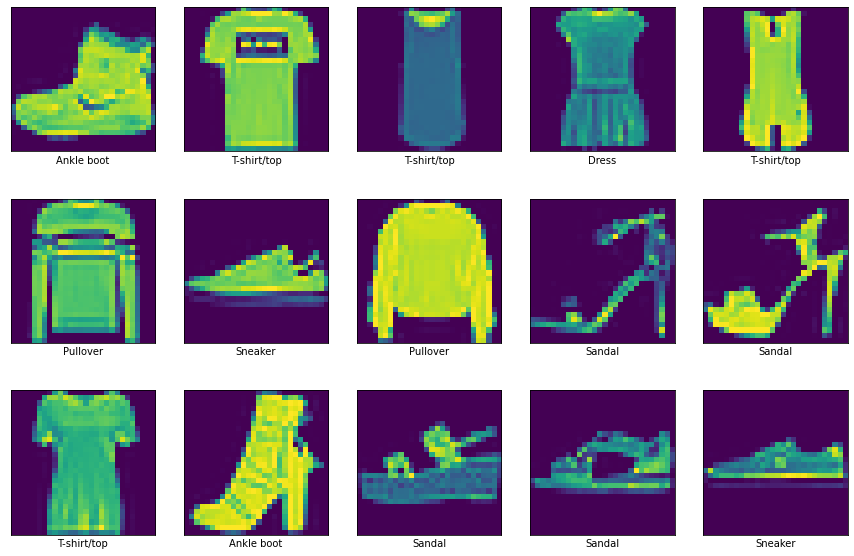

In [111]:
plt.figure(figsize=(15,10))

for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.viridis)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

## Model - Keras Fit

In [191]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

**Flatten :** 
- 2D (28*28) to 1D 784 pixels

**Dense Layer :** 
- Densly connected layers
- DenseLayer I (512 Neurons)
- DenseLayer II Returns a logits array with length of 10
    - Each node contains a score that indicates the current image belogs to one of the 10 classes

### Model Composition


In [192]:
model = create_model()
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

# Tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# %tensorboard --logdir logs/fit

### Train

In [193]:
model.fit(x=train_images, 
          y=train_labels, 
          epochs=10, 
          validation_data=(test_images, test_labels), 
          callbacks=[tensorboard_callback])

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4970 - accuracy: 0.8211 - val_loss: 0.4335 - val_accuracy: 0.8441
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3820 - accuracy: 0.8603 - val_loss: 0.3886 - val_accuracy: 0.8631
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3478 - accuracy: 0.8722 - val_loss: 0.3624 - val_accuracy: 0.8681
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3271 - accuracy: 0.8801 - val_loss: 0.3613 - val_accuracy: 0.8652
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3135 - accuracy: 0.8826 - val_loss: 0.3668 - val_accuracy: 0.8685
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3026 - accuracy: 0.8867 - val_loss: 0.3574 - val_accuracy: 0.8740
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2918 - accuracy: 0.8913 - val_loss: 0.3351 - val_accuracy:

### Evaluate

*Overfitting :* accuracy difference  (training set- testing set)

In [194]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3477 - accuracy: 0.8813

Test accuracy: 0.8812999725341797


## Model - GradientTape

In [131]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(60000).batch(64)
test_dataset = test_dataset.batch(64)

In [132]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [133]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [134]:
def train_step(model, optimizer, train_images, train_labels):
  with tf.GradientTape() as tape:
    predictions = model(train_images, training=True)
    loss = loss_object(train_labels, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_train, predictions)

def test_step(model, test_images, test_labels):
  predictions = model(test_images)
  loss = loss_object(test_labels, predictions)

  test_loss(loss)
  test_accuracy(test_labels, predictions)

In [135]:
# Tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# %tensorboard --logdir logs/gradient_tape

In [136]:
model = create_model() # reset our model

EPOCHS = 10

for epoch in range(EPOCHS):
  for (x_train, y_train) in train_dataset:
    train_step(model, optimizer, x_train, y_train)
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  for (x_test, y_test) in test_dataset:
    test_step(model, x_test, y_test)
  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
  
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

  # Reset metrics every epoch
  train_loss.reset_states()
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.5082747936248779, Accuracy: 81.92166900634766, Test Loss: 0.4248839020729065, Test Accuracy: 84.5999984741211
Epoch 2, Loss: 0.3823310434818268, Accuracy: 86.13166809082031, Test Loss: 0.38134482502937317, Test Accuracy: 86.1500015258789
Epoch 3, Loss: 0.3469604253768921, Accuracy: 87.2316665649414, Test Loss: 0.3731890022754669, Test Accuracy: 86.81999969482422
Epoch 4, Loss: 0.32197749614715576, Accuracy: 88.13666534423828, Test Loss: 0.3543870151042938, Test Accuracy: 86.87000274658203
Epoch 5, Loss: 0.31073254346847534, Accuracy: 88.48333740234375, Test Loss: 0.36078229546546936, Test Accuracy: 87.01000213623047
Epoch 6, Loss: 0.29626724123954773, Accuracy: 88.91666412353516, Test Loss: 0.3286523222923279, Test Accuracy: 88.23999786376953
Epoch 7, Loss: 0.2843831479549408, Accuracy: 89.41666412353516, Test Loss: 0.32824501395225525, Test Accuracy: 88.12000274658203
Epoch 8, Loss: 0.27645906805992126, Accuracy: 89.68499755859375, Test Loss: 0.3326510190963745, Test 

### Predict

- Probabilities ( Softmax Layer )

In [197]:
predictions = model.predict(test_images)

- Prediction is an array of 10 numbers representing 'Models Confidence'
- Label with the higest confidence value

In [198]:
np.argmax(predictions[87])

2

In [199]:
test_labels[87]

2

In [200]:
def plot_image(i, predictions_array, true_label, img):
    
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.viridis)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('#ebcb8b')
    thisplot[true_label].set_color('#d08770')


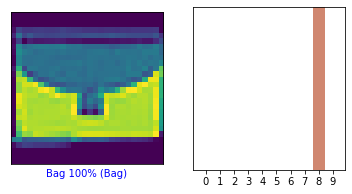

In [201]:
i = 78
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

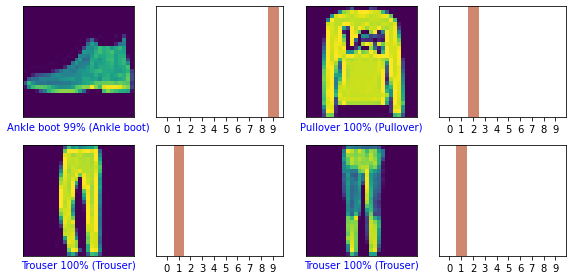

In [202]:
num_rows, num_cols = 2,2
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Usage

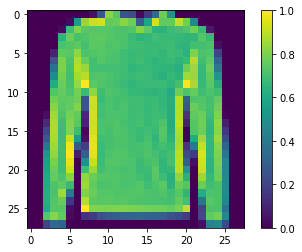


Shape:
 (28, 28)


In [206]:
img = test_images[55]

plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

print('\nShape:\n', img.shape)

In [207]:
# batching images : (in following case - single member of batch )

img = (np.expand_dims(img,0))
print('\nShape:\n', img.shape)


Shape:
 (1, 28, 28)



Predicted label: 9


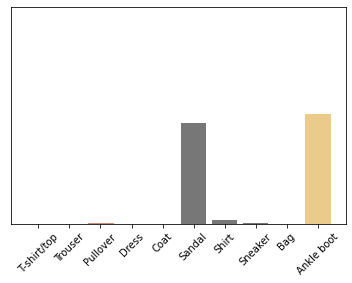

In [208]:
predictions_single = probability_model.predict(img)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

print('\nPredicted label:', np.argmax(predictions_single[0]))

***